# Compuertas a nivel de pulsos
(Tutorial introductorio)

La mayoría de los algoritmos pueden ser descritos solamente con operaciones de circuitos. Cuando es necesario precisar más control sobre la implementación a bajo nivel del programa (i.e., circuito/algoritmo cuántico) podemos usar "pulse gates" o compuertas de pulsos. Las _Pulse gates_, elimina la restricción de la ejecución de circuitos solamente utilizando la base de compuertas, y también permite sobre-escribir la implementación por defecto de cada base de compuertas.

Las _Pulse gates_ permiten hacer un mapa a un circuito lógico e.g., ```X``` a un programa de Qiskit Pulse, llamado "_schedule_" (calendario en castellano). Este mapa se le denota como "_calibration_" o calibración en castellano. Una calibración con alta fidelidad es aquella que implementa fielmente las operaciones lógicas fielmente, y que implementa la operación lógica desde la cual es asignada. Es decir, el desempeño de la operación ```X```, tal que la calibración en efecto transforme $|0\rangle \rightarrow |1\rangle$.


Un _Schedule_ (calendario) especifíca el tiempo exacto de la dinámica en de cada una de las señales de entrada a lo largo de todos los canales ("_channels_") de entrada del dispositivo. Usualmente, hay múltiples canales para cada _qubit_, tales como los de manipulación y de medida ("_drive_" y "_measure_" respectivamente en inglés). Esta interface es más potente y requiere de una comprensión más profunda de la física que ocurre en los dispositivos.

Es importante notar que los programas de _Pulse_ operan con _qubits_ físicos. Un pulso que manipulación sobre un _qubit_ "a", no actúa como la misma operación lígca en el estado de un _qubit_ "b". En otras palabras, las calibraciones son unicas para cada _qubit_ y no se pueden intercambiar entre _qubits_. Esto es diferente en la programación al nivel de circuitos cuánticos, donde la compuerta ```X``` es definida independientemente sobre el _qubit_ físico sobre el que esté operando.

Este tutorial muestra como añadir calibraciones a tu circuito de manera que el programa del circuito a alto nivel sea "consciente" de la física subyacente.

<div class="alert alert-block alert-info"> <b>NOTA</b> <br>
    <br>
    Para ejecutar las compuertas con pulso, el <code>backend</code> tiene que estar habilitado con <i>OpenPulse</i>. Puede ser chequeado utilizando:
    <br>
<br><code>backend.configuration().open_pulse</code><br>    
    <br>
    el cual debe estar habilitado (<code>True</code>) cuando <i>OpenPulse</i> se encuentre activado. Si esta habilitado y las características de "<i>pulse gates</i>" no lo esten, pueden agendar el circuito de entrada.

</div>



# Preparación de librerías

Comencemos importando todas las funciones y librerías que vayamos a usar, recuerda que al ejecutar esta librería las funciones y paquetes de python quedan cargados en la memoria, al reinicializar el kernel es necesario volver a ejecutar esta celda.

In [17]:
#Para la construccion de circuitos cuanticos
from qiskit import QuantumCircuit, execute

#Para la construccion de las calibraciones y su vinculacion
from qiskit import pulse, transpile
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia, FakeHanoi

#Compuertas personalizadas
from qiskit.circuit import Gate
from qiskit import QiskitError

#informacion
import qiskit.tools.jupyter


## Construyendo el circuito

Comencemos haciendo un circuito relativamente sencillo, que genere un estado de Bell. El estado de Bell es un estado de dos _qubits_ que presenta máximo nivel de entrelazamiento. 

Este circuito se compone de una compuerta Hadamard (H) en el _qubit_ 0 y una compuerta de dos _qubits_ control ```X``` (CNOT) con el _qubit_ 0 como control, y el _qubit_ 1 como _target_. Al final del circuito dos compuertas de medidas para cada _qubit_.

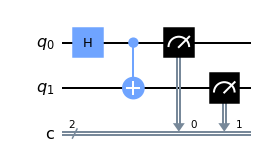

In [27]:
circ = QuantumCircuit(2, 2);
circ.h(0);
circ.cx(0, 1);
circ.measure(0, 0);
circ.measure(1, 1);

circ.draw('mpl');

In [32]:
result = execute(circ, backend=FakeValencia()).result();
counts = result.get_counts();
print("El resultado de la estadística es: \n|00>: {S00}  \n|01>: {S01}  \n|10>: {S10}  \n|11>: {S11}".format(S00=counts['00'],S01=counts['01'],S10=counts['10'],S11=counts['11']))

El resultado de la estadística es: 
|00>: 489  
|01>: 33  
|10>: 24  
|11>: 478


## Construyendo las calibraciones

Ahora es momento de definir la calibración de una de las compuetas, elijamos la compuerta Hadamard sobre el _qubit_ 0.

En la practica, la forma de pulso y sus parametros serán optimizados a través de una serie de experimentos llamados [Experimentos de Rabi (Qiskit Textbook)](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html).

Para esta demostración, la compuerta Hadamard será un pulso Gaussiano. Reproduciremos (```play```) este pulso en el canal de manipulación (```drive channel```) del _qubit_ 0.

Trabajaremos a más detalle con las calibraciones en otro tutorial sobre construcción de _Schedules_.

In [41]:
backend = FakeValencia();

with pulse.build(backend, name='hadamard') as h_q0:
    pulse.play(Gaussian(duration=100, amp=0.1, sigma=3), pulse.drive_channel(0));


Graficamos el pulso:

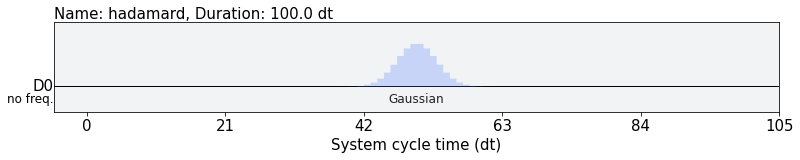

In [42]:
h_q0.draw()

Ahora usaremos de ahora en adelante el siguiente pulso con:

    -Duración del pulso 128 muestras para período de muestreo de 16,
    -Amplitud de la función gaussiana de 1
    -Desviación estándar de 16.

In [3]:
backend = FakeValencia()ñ

with pulse.build(backend, name='hadamard') as h_q0:
    pulse.play(Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0))

Graficamos el pulso:

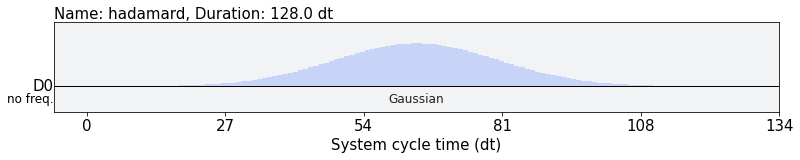

In [4]:
h_q0.draw()

## Vincula la calibracion con tu circuito

Ahora que tenemos la calibración, queda completar el registro de la misma en el circuito cuántico. El método ```add_calibration``` necesita información sobre la compuerta y la referencia del calendario (_schedule_) para completar el mapa:

```QuantumCircuit.add_calibration(gate, qubits, schedule, parameters)```

```gate``` puede ser o bien un objeto tipo ```circuit.Gate``` o el nombre la compuerta. ***Usualmente, puedes necesitar un _schedule_ diferente para set de _qubits_ y _parameters_.*** Ya que la compuerta Hadamard no require de ningún parámetro (no es una compuerta paramétrica), no añadimos ninguno.

In [5]:
circ.add_calibration('h', [0], h_q0)

Finalmente, nota que el _transpiler_ va a respetar tus calibraciones. Úsalas como tu normalmente lo harías (este ejemplo es un muy sencillo para que el transpilador lo optimice.)

['id', 'rz', 'sx', 'x', 'cx', 'reset']


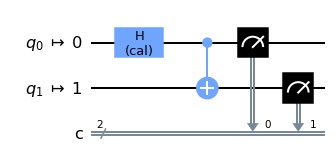

In [6]:
backend = FakeHanoi()

circ = transpile(circ, backend)

print(backend.configuration().basis_gates)
circ.draw('mpl', idle_wires=False)

In [43]:
result = execute(circ, backend=FakeValencia()).result();
counts = result.get_counts();
print("El resultado de la estadística es: \n|00>: {S00}  \n|01>: {S01}  \n|10>: {S10}  \n|11>: {S11}".format(S00=counts['00'],S01=counts['01'],S10=counts['10'],S11=counts['11']))

El resultado de la estadística es: 
|00>: 512  
|01>: 38  
|10>: 29  
|11>: 445


Nota que ```h``` no es una base para el _backend_ simulado de ```FakeHanoi```. Ya que hemos añadido una calibración para ello, el transpilador va a tratar nuestra compuerta como una compuerta de la base; sin embargo, solamente para los _qubits_ a los cuales se la ha definido. Una compuerta Hadamard aplicada a un _qubit_ distinto, se le descompondrá en su base de compuertas.

## Compuertas personalizadas

Vamos a mostrar brevemente como es el procedimeinto no-estandarizado de compuertas personalizadas. Esta demostración incluye una compuerta con parámetros.

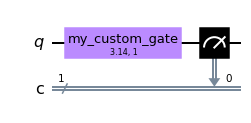

In [7]:
circ = QuantumCircuit(1, 1)
custom_gate = Gate('my_custom_gate', 1, [3.14, 1])
# 3.14 is an arbitrary parameter for demonstration
circ.append(custom_gate, [0])
circ.measure(0, 0)

circ.draw('mpl')

In [9]:
with pulse.build(backend, name='custom') as my_schedule:
    pulse.play(Gaussian(duration=64, amp=0.2, sigma=8), pulse.drive_channel(0))

circ.add_calibration('my_custom_gate', [0], my_schedule, [3.14, 1])
# Alternatively: circ.add_calibration(custom_gate, [0], my_schedule)

Si usamos la variable ```custom_gate``` de la instancia ```Gate``` para añadir la calibración, los parámetros son derivados de la instancia. Recuerda que el orden de los parámetros es importante.

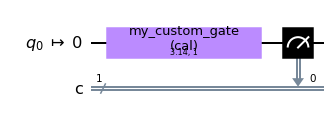

In [10]:
circ = transpile(circ, backend)
circ.draw('mpl', idle_wires=False)

Normalmente, si intentamos transpilar nuestro ```circ```, puede que obtengamos un error. Ya que una definicion funcional no ha sido provista para ```my_custom_gate```, el transpilador no puede descomponerla en la base del conjunto de compuerta del dispositivo seleccionado. Podemos mostrar esto, intentando añadir ```my_custom_gate``` a otro _qubit_ que no ha sido calibrado.

In [11]:
circ = QuantumCircuit(2, 2)
circ.append(custom_gate, [1])


from qiskit import QiskitError
try:
    circ = transpile(circ, backend)
except QiskitError as e:
    print(e)

"Cannot unroll the circuit to the given basis, ['id', 'rz', 'sx', 'x', 'cx', 'reset']. Instruction my_custom_gate not found in equivalence library and no rule found to expand."


---

Basado en [este notebook tutorial](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/circuits_advanced/05_pulse_gates.ipynb), para el [Qiskit Fall Fest - Venezuela (Universidad Simón Bolívar)](www.cofalumniusb.org/qiskit-fall).


Adaptado y traducido por: [**Manuel Morgado**](morgadovargas@unistra.fr) | Université de Strasbourg et Centre Européen de Sciences Quantiques 

In [15]:
%qiskit_version_table
%qiskit_copyright